In [1]:
import numpy as np
import numpy.linalg as LA
from matplotlib import pyplot as plt
from scipy.integrate import odeint
# import pandas as pd 
import pickle
import sys, os 
sys.path.append(os.path.abspath("..")) # Adds the parent folder to sys.path
from utils import *
from Robots import *
from Controller import *

# Simulation

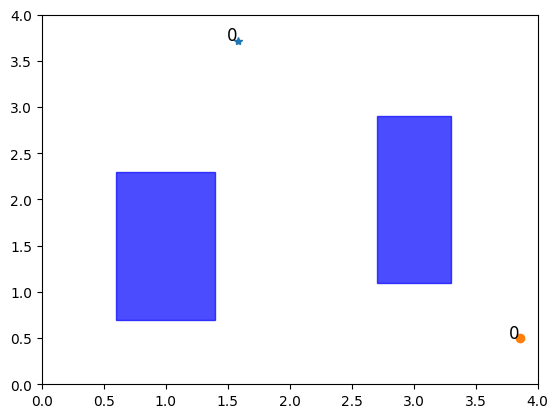

In [2]:
# List of obstacles
with_obs = True
if with_obs:
    Obs = [
        obstacle(1.0, 1.5, 0.8, 1.6, 0.),
        obstacle(3.0, 2.0, 1.8, 0.6, np.pi/2)
    ]
else:
    Obs = []
n_obs = len(Obs)
bounds = {
    "x_max": 4.0, "x_min": 0.0, 
    "y_max": 4.0, "y_min": 0.0,
    "v_max": 0.5, "v_min": -0.5, 
    "u_max": 0.5, "u_min": -0.5, 
}
d_min = 0.25
M = 1
# generate the goal positions
# np.random.seed(7)
goals = goal_position(Obs, bounds, d_min+0.1, M)

# generate the initial position so that no collision avoidance constraint is violated
p_init = init_position(Obs, goals, bounds, d_min+0.1, M, d_sep=4.0, d_dec=0.05)

# Visualize the scenario
from matplotlib.patches import Polygon
fig, ax = plt.subplots()
ax.set_xlim(bounds["x_min"], bounds["x_max"]) 
ax.set_ylim(bounds["y_min"], bounds["y_max"]) 
ax.plot(goals[0, :], goals[1, :], "*")
for i in range(goals.shape[1]):
    ax.text(goals[0, i], goals[1, i], str(i), fontsize=12, ha='right')
ax.plot(p_init[0, :], p_init[1, :], "o")
for i in range(p_init.shape[1]):
    ax.text(p_init[0, i], p_init[1, i], str(i), fontsize=12, ha='right')

for o in Obs:
    corners = [o.p1, o.p2, o.p3, o.p4]
    polygon = Polygon(corners, closed=True, color="b", alpha=0.7)
    ax.add_patch(polygon)


In [3]:
T = 0.25; H = 10
Robots = [robot(T, p_init[:,i], np.zeros(2)) for i in range(M)]
Ctrl = controller(T, H, M)
Ctrl.set_params(bounds, d_min, Wu=1e0, Wp=1e0, Wpt=1e1)
Ctrl.set_goals_obstacles(goals, Obs)
all_p = np.hstack([rob.p for rob in Robots])
all_v = np.hstack([rob.v for rob in Robots])
Ctrl.set_state(all_p, all_v)
Obs_info = np.array([[o.x_c, o.y_c, o.theta, o.L, o.W] for o in Obs]).T

In [5]:
Ctrl.SOL_disc["BO"]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [4]:
# The main loop
N_step = 100
for t in range(N_step):
    print("Time step: ", t)
    all_p = np.hstack([rob.p for rob in Robots])
    all_v = np.hstack([rob.v for rob in Robots])
    Ctrl.set_state(all_p, all_v)
    Ctrl.find_cpl_rbs()
    Ctrl.solve_MIQP()

    # Now move the robots
    U_ctrl = Ctrl.SOL_cont["U"][:, 0].reshape([2,-1], order = 'F')
    for i in range(M):
        Robots[i].run(U_ctrl[:,i], t*T)

    if Ctrl.reaching_goals():
        break

Time step:  0
Time step:  1
Time step:  2
Time step:  3
Time step:  4
Time step:  5
Time step:  6
Time step:  7
Time step:  8
Time step:  9
Time step:  10
Time step:  11
Time step:  12
Time step:  13
Time step:  14
Time step:  15
Time step:  16
Time step:  17
Time step:  18
Time step:  19
Time step:  20
Time step:  21
Time step:  22
Time step:  23
Time step:  24
Time step:  25
Time step:  26
Time step:  27
Time step:  28
Time step:  29
Time step:  30
Time step:  31
Time step:  32
Time step:  33
Time step:  34
Time step:  35
Time step:  36
Time step:  37
Time step:  38
Time step:  39
Time step:  40
Time step:  41


In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(bounds["x_min"], bounds["x_max"])
ax.set_ylim(bounds["y_min"], bounds["y_max"])
ax.plot(goals[0, :], goals[1, :], "*", markersize=20)
for o in Obs:
    corners = [o.p1, o.p2, o.p3, o.p4]
    polygon = Polygon(corners, closed=True, color="b", alpha=0.7)
    ax.add_patch(polygon)
for rob in Robots:
    ax.plot(rob.X_hist[0,:], rob.X_hist[1, :], "o--")


# Video of the Navigation

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(bounds["x_min"], bounds["x_max"])
ax.set_ylim(bounds["y_min"], bounds["y_max"])

# Static elements
ax.plot(goals[0, :], goals[1, :], "*", markersize=20)  # Plot goals
for o in Obs:
    corners = [o.p1, o.p2, o.p3, o.p4]
    polygon = Polygon(corners, closed=True, color="b", alpha=0.7)
    ax.add_patch(polygon)

# Dynamic elements
robot_lines = []
for rob in Robots:
    line, = ax.plot([], [], "o--")  # Initialize empty lines for robots
    robot_lines.append(line)

# Initialization function
def init():
    for line in robot_lines:
        line.set_data([], [])
    return robot_lines

# Update function
def update(frame):
    for rob, line in zip(Robots, robot_lines):
        line.set_data(rob.X_hist[0, :frame+1], rob.X_hist[1, :frame+1])
    return robot_lines

# Create animation
num_frames = Robots[0].X_hist.shape[1]
ani = FuncAnimation(fig, update, frames=num_frames, init_func=init, blit=True)

# Save or display the animation
HTML(ani.to_html5_video())
# plt.show()  # Uncomment this to display in an interactive session